# Exploring RNN architectures for Quantum state representation

A couple types of rnn:
    
    Gru
    
    Lstm
    
    2D lstm (if we have a 2d input)
    
    Tranformer (masked) (masked makes it causal whereas unmasked would be non causal)
    
Extra networks:

    Echo state networks  -> look into
    
    Resevoir computing cells -> look into
        
        Apparently you only train the output weights -> avoids a bunch of backprop
        
        but we use it in a recurrent fashion so you need to backprop still
        
        Look at BYOL for this (might not be possible)
    
    

# Quantum state to represent

- Start with Rydberg system

Transverse and longitudinal view of ising model

Excited state encourages nearby (within radius $R_b$)states to tend towards ground states

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math,time
import torch
from torch import nn
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
from numba import cuda

cuda:0


In [2]:
# Hamiltonian parameters
Lx = 16      # Linear size in x direction
Ly = 16      # Linear size in y direction
N = Lx*Ly   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 
exact_energy = {16:-0.45776822,64:-0.40522,144:-0.38852,256:-0.38052}[Lx*Ly]
print(exact_energy)

-0.38052


In [3]:
class Sampler(nn.Module):
    def __init__(self,device=device):
        self.device=device
        super(Sampler, self).__init__()
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        raise NotImplementedError
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        raise NotImplementedError
    
    def sample_with_labels(self,B,L,grad=False):
        """Inputs:
            B (int) - The number of states to generate in parallel
            L (int) - The length of generated vectors
            grad (boolean) - Whether or not to use gradients
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logppl - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i+B*j] had one spin flipped at position j
                    relative to s[i]
        """
        sample=self.sample(B,L)
        sflip = torch.zeros([B,L,L,1],device=self.device)
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:,j] = sample*1.0
            sflip[:,j,j] = 1-sflip[:,j,j]
        #compute all of their logscale probabilities
        if not grad:
            with torch.no_grad():
                probs = self.logprobability(sflip.view([B*L,L,1]))
        else:
            probs = self.logprobability(sflip.view([B*L,L,1]))
            
        #might make sflip shape [B,L] in the future
        return sample,probs.reshape([B,L])
    
    def sample_with_labelsALT(self,B,L,grad=False):
        """Returns:
            samples  - [B,L,1] matrix of zeros and ones for ground/excited states
            logsqrtp - size B vector of average (log p)/2 values used for numerical stability 
                       when calculating sum_s'(sqrt[p(s')/p(s)]) 
            sumsqrtp - size B vector of exp(-logsqrtp)*sum(sqrt[p(s')]).
        """
        sample,probs = self.sample_with_labels(B,L,grad)
        #get the average of our logprobabilities and divide by 2
        logsqrtp=probs.mean(dim=1)/2
        #compute the sum with a constant multiplied to keep the sum closeish to 1
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    
    

In [4]:
help(Sampler)

Help on class Sampler in module __main__:

class Sampler(torch.nn.modules.module.Module)
 |  Sampler(device=device(type='cuda', index=0))
 |  
 |  Base class for all neural network modules.
 |  
 |  Your models should also subclass this class.
 |  
 |  Modules can also contain other Modules, allowing to nest them in
 |  a tree structure. You can assign the submodules as regular attributes::
 |  
 |      import torch.nn as nn
 |      import torch.nn.functional as F
 |  
 |      class Model(nn.Module):
 |          def __init__(self):
 |              super(Model, self).__init__()
 |              self.conv1 = nn.Conv2d(1, 20, 5)
 |              self.conv2 = nn.Conv2d(20, 20, 5)
 |  
 |          def forward(self, x):
 |              x = F.relu(self.conv1(x))
 |              return F.relu(self.conv2(x))
 |  
 |  Submodules assigned in this way will be registered, and will have their
 |  parameters converted too when you call :meth:`to`, etc.
 |  
 |  :ivar training: Boolean represents whethe

# Simple RNN to start


In [5]:
class RNN(Sampler):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    def __init__(self,rnntype="GRU",Nh=128,device=device, **kwargs):
        super(RNN, self).__init__(device=device)
        #rnn takes input shape [B,L,1]
        self.rnn = RNN.TYPES[rnntype](input_size=1,hidden_size=Nh,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        
        self.rnntype=rnntype
        self.to(device)
    def forward(self, input):
        # h0 is shape [d*numlayers,B,H] but D=numlayers=1 so
        # h0 has shape [1,B,H]
        
        if self.rnntype=="LSTM":
            h0=[torch.zeros([1,input.shape[0],128],device=self.device),
               torch.zeros([1,input.shape[0],128],device=self.device)]
            #h0 and c0
        else:
            h0=torch.zeros([1,input.shape[0],128],device=self.device)
        out,h=self.rnn(input,h0)
        return self.lin(out)
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you muptiply your conditional probability by pred[i]
        #if real[i]=0 than you muliply by 1-pred[i]
        
        #probability predictions should be done WITH gradients
        #with torch.no_grad():
        
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        if self.rnntype=="LSTM":
            h=[torch.zeros([1,B,128],device=self.device),
               torch.zeros([1,B,128],device=self.device)]
            #h is h0 and c0
        else:
            h=torch.zeros([1,B,128],device=self.device)
        #Sample set will have shape [N,L,1]
        #need one extra zero batch at the start for first pred hence input is [N,L+1,1] 
        input = torch.zeros([B,L+1,1],device=self.device)
        #sampling can be done without gradients
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]
            
            out,h=self.rnn(input[:,idx-1:idx,:],h)
            out=out[:,0,:]
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(out)
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[:,idx,:]=sample
        #input's first entry is zero to get a predction for the first atom
        return input[:,1:,:]
    

In [6]:
@cuda.jit
def Vij(Ly,Lx,Rcutoff,V,matrix):
    #matrix will be size [Lx*Ly,Lx*Ly]
    
    i,j=cuda.grid(2)
    if i>Ly or j>Lx:
        return
    R=Rcutoff**6
    #flatten two indices into one
    idx = Ly*j+i
    # only fill in the upper diagonal
    for k in range(idx+1,Lx*Ly):
        #expand one index into two
        i2 = k%Ly
        j2=k//Ly
        div = ((i2-i)**2+(j2-j)**2)**3
        if div<=R:
            matrix[idx][k]=V/div
    

class Hamiltonian():
    def __init__(self,Lx,Ly,V,Omega,delta,R=2.01,device=device):
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.Omega    = Omega           # Rabi frequency
        self.delta    = delta           # Detuning
        self.L        = Lx * Ly         # Number of spins
        self.device   = device
        self.R=R
        self.buildlattice()
        
    def buildlattice(self):
        Lx,Ly=self.Lx,self.Ly
        
        #diagonal hamiltonian portion can be written as a matrix multiplication then a dot product
        self.Vij=nn.Linear(self.L,self.L).to(device)
        
        mat=np.zeros([self.L,self.L])
        
        Vij[(1,1),(Lx,Ly)](Lx,Ly,self.R,self.V,mat)
        with torch.no_grad():
            self.Vij.weight[:,:]=torch.Tensor(mat)
            self.Vij.bias.fill_(-self.delta)


    def localenergy(self,samples,logp,logppj):
        """
        Takes in s, ln[p(s)] and ln[p(s')] (for all s'), then computes Hloc(s) for N samples s.
        
        Inputs:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logp - size B vector of logscale probabilities ln[p(s)]
            logppj - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i][j] had one spin flipped at position j
                    relative to s[i]
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B,device=self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        #flip ONE spin here and get sqrt(p(s)/p(s'))
        #then sum over all spin flips
        #think of ways to cheat
        
        #logppj is shape [B*L]
        # the first N labels in logppj are the log probabilities for
        # the N states but with the first state flipped (ground-> excited and excited-> ground)
        # the second N all were calculated with only the second state flipped 
        # etc...
        for j in range(self.L):
            #logpflip is log(p(1-s))
            #logp is log(p(s))?
            #s' has one spin flipped at j
            #with psi(s)=sqrt(p(s)), sigma_i^x = psi(s')/psi(s)?
            
            #make sure torch.exp is a thing
            eloc += -0.5*self.Omega * torch.exp((logppj[:,j]-logp)/2)

        return eloc
    def localenergyALT(self,samples,logp,sumsqrtp,logsqrtp):
        """
        Takes in s, ln[p(s)] and exp(-logsqrtp)*sum(sqrt[p(s')]), then computes Hloc(s) for N samples s.
        
        Inputs:
            samples  - [B,L,1] matrix of zeros and ones for ground/excited states
            logp     - size B vector of logscale probabilities ln[p(s)]
            logsqrtp - size B vector of average (log p)/2 values used for numerical stability 
                       when calculating sum_s'(sqrt[p(s')/p(s)]) 
            sumsqrtp - size B vector of exp(-logsqrtp)*sum(sqrt[p(s')]).
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B,device=self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        #flip ONE spin here and get sqrt(p(s)/p(s'))
        #then sum over all spin flips
        #think of ways to cheat
        
        eloc += -0.5*self.Omega *sumsqrtp* torch.exp(logsqrtp-logp/2)

        return eloc


In [7]:
help(Hamiltonian)

Help on class Hamiltonian in module __main__:

class Hamiltonian(builtins.object)
 |  Hamiltonian(Lx, Ly, V, Omega, delta, R=2.01, device=device(type='cuda', index=0))
 |  
 |  Methods defined here:
 |  
 |  __init__(self, Lx, Ly, V, Omega, delta, R=2.01, device=device(type='cuda', index=0))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  buildlattice(self)
 |  
 |  localenergy(self, samples, logp, logppj)
 |      Takes in s, ln[p(s)] and ln[p(s')] (for all s'), then computes Hloc(s) for N samples s.
 |      
 |      Inputs:
 |          samples - [B,L,1] matrix of zeros and ones for ground/excited states
 |          logp - size B vector of logscale probabilities ln[p(s)]
 |          logppj - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i][j] had one spin flipped at position j
 |                  relative to s[i]
 |      Returns:
 |          size B vector of energies Hloc(s)
 |  
 |  localenergyALT(self, samples, logp, sumsqrtp, logsqrtp)
 | 

In [8]:
testrnn = RNN(rnntype="LSTM")
print(testrnn.rnntype)
x=torch.zeros([10,4*4,1]).to(device)
print(testrnn(x).shape)
sample = testrnn.sample(10,4*4)
print(sample.shape)

sample,pflip = testrnn.sample_with_labels(10,4*4,grad=False)
logp=testrnn.logprobability(sample)
print(sample.shape,pflip.shape)
print(logp[0],'\n',pflip[::10])

print(testrnn)

LSTM
torch.Size([10, 16, 1])
torch.Size([10, 16, 1])
torch.Size([10, 16, 1]) torch.Size([10, 16])
tensor(-11.0885, device='cuda:0', grad_fn=<SelectBackward>) 
 tensor([[-11.0639, -11.0646, -11.1141, -11.1137, -11.1137, -11.0658, -11.1144,
         -11.0643, -11.0640, -11.1143, -11.0644, -11.0652, -11.1136, -11.1136,
         -11.1134, -11.0661]], device='cuda:0')
RNN(
  (rnn): LSTM(1, 128, batch_first=True)
  (lin): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [9]:
def new_rnn_with_optim(rnntype,Nh,lr=1e-3,beta1=0.9,beta2=0.999):
    rnn = RNN(rnntype=rnntype,Nh=Nh)
    optimizer = torch.optim.Adam(
    rnn.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
    )
    return rnn,optimizer

In [10]:
h = Hamiltonian(Lx,Ly,V,Omega,delta)

In [11]:
bsize=512

testrnn,optimizer=new_rnn_with_optim("GRU",128,lr=1e-3)
samplernn = RNN(rnntype="GRU",Nh=128)
with torch.no_grad():
    print(testrnn(torch.zeros([1,4,1],device=device))[0,:,0])
    print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])

tensor([0.4888, 0.4875, 0.4868, 0.4865], device='cuda:0')
tensor([0.5226, 0.5246, 0.5256, 0.5261], device='cuda:0')


In [12]:
def momentum_update(m, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(target_param.data*m + param.data*(1-m))
with torch.no_grad():
    momentum_update(0.0,samplernn,testrnn)
    


In [13]:
with torch.no_grad():
    print(testrnn(torch.zeros([1,4,1],device=device))[0,:,0])
    print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])

tensor([0.4888, 0.4875, 0.4868, 0.4865], device='cuda:0')
tensor([0.4888, 0.4875, 0.4868, 0.4865], device='cuda:0')


# Training with Memory Queue

In [14]:
USEQUEUE=True
losses=[]

In [15]:
M=0.9
BlockNum=(Lx*Ly)//8
BbyL=bsize//BlockNum

print(BbyL*BlockNum)
samplequeue = torch.zeros([bsize,Lx*Ly,1]).to(device)
sump_queue=torch.zeros([bsize]).to(device)
sqrtp_queue=torch.zeros([bsize]).to(device)
Eo_queue = torch.zeros([BlockNum]).to(device)


for i in range(BlockNum):
    sample,sump,sqrtp = samplernn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False)
    with torch.no_grad():
        samplequeue[i*BbyL:(i+1)*BbyL]=sample
        sump_queue[i*BbyL:(i+1)*BbyL]=sump
        sqrtp_queue[i*BbyL:(i+1)*BbyL]=sqrtp

if not USEQUEUE:
    nqueue_updates = BlockNum
else:
    nqueue_updates=1


i=0
t=time.time()
for x in range(12000):
    
    for k in range(nqueue_updates):
        sample,sump,sqrtp = samplernn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False)
        
        with torch.no_grad():
            #create and store true values for energy
            lp=samplernn.logprobability(sample)
            E_i=h.localenergyALT(sample,lp,sump,sqrtp)
            Eo_queue[i]=E_i.mean()/(Lx*Ly)
            samplequeue[i*BbyL:(i+1)*BbyL]=sample
            sump_queue[i*BbyL:(i+1)*BbyL]=sump
            sqrtp_queue[i*BbyL:(i+1)*BbyL]=sqrtp
        i=(i+1)%BlockNum
    
    logp=testrnn.logprobability(samplequeue)
    
    with torch.no_grad():
        E=h.localenergyALT(samplequeue,logp,sump_queue,sqrtp_queue)
        Eo=E.mean()
            
    loss = (E*logp - Eo*logp).mean()
    
    ERR  = Eo/(Lx*Ly)
    losses.append(ERR.cpu().item())
    
    testrnn.zero_grad()
    #if Energy sees an unrealistic improvement
    #ignore this at early stages
    if x>500 and Eo_queue.min()-losses[-1]>0.2:
        print("s",end="")
        #update momentum and comtinue
        with torch.no_grad():
            momentum_update(M,samplernn,testrnn)
        continue
        
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        momentum_update(M,samplernn,testrnn)
    
    
    if x%500==0:
        print(int(time.time()-t),end=",%.2f|"%(losses[-1]))
print(time.time()-t)

512
0,2.50|69,-0.24|138,-0.29|206,-0.31|275,-0.31|344,-0.33|413,-0.33|482,-0.34|ssssssssssssssssssssss551,-0.33|619,-0.35|688,-0.35|sssss757,-0.36|825,-0.36|894,-0.37|ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss961,-0.34|1029,-0.37|1098,-0.37|1166,-0.37|1235,-0.37|1303,-0.38|sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss1439,-0.37|1507,-0.38|1576,-0.38|1644.6915180683136


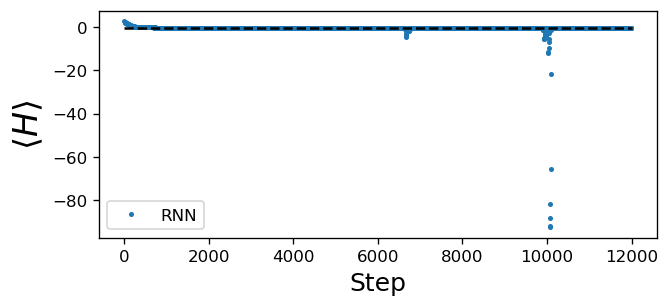

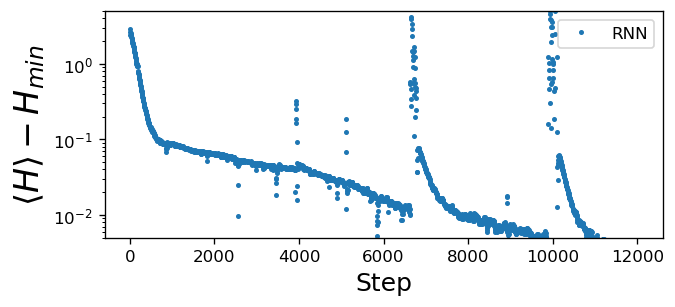

In [16]:

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

plt.plot(losses,marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.plot([0,len(losses)],[exact_energy,exact_energy],'k--')

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")

plt.show()

fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(abs(np.array(losses)-exact_energy),marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN")
plt.yscale("log")
plt.ylim(5e-3,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")

plt.show()

In [17]:
print(losses[-1]-exact_energy,losses[-1])

0.003295226831436182 -0.37722477316856384


In [18]:
for k in range(BlockNum):
    sample,sump,sqrtp = testrnn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False)
    with torch.no_grad():
        samplequeue[i*BbyL:(i+1)*BbyL]=sample
        sump_queue[i*BbyL:(i+1)*BbyL]=sump
        sqrtp_queue[i*BbyL:(i+1)*BbyL]=sqrtp
    i=(i+1)%BlockNum
logp=testrnn.logprobability(samplequeue)
with torch.no_grad():
    E=h.localenergyALT(samplequeue,logp,sump_queue,sqrtp_queue)
    Eo=E.mean()

ERR  = Eo/(Lx*Ly)

print(ERR.detach().item())

-0.3781787157058716


In [19]:
import os


os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

0

In [20]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [21]:
x=torch.zeros(10)
x.min().item()

0.0